# Tensorflow Linear Regression

TensorFlow was created by Google Brain and is used for doing machine learning in neural networks. On the other hand, to use deep learning approaches, you will need large data to train. If not enough data, the model will be overfitting. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# fix_yahoo_finance is used to fetch data 
import fix_yahoo_finance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AMD'
start = '2007-01-01'
end = '2018-11-01'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,20.080000,20.400000,19.350000,19.520000,19.520000,28350300
2007-01-04,19.660000,19.860001,19.320000,19.790001,19.790001,23652500
2007-01-05,19.540001,19.910000,19.540001,19.709999,19.709999,15902400
2007-01-08,19.709999,19.860001,19.370001,19.469999,19.469999,15814800
2007-01-09,19.450001,19.709999,19.370001,19.650000,19.650000,14494200


In [3]:
dataset['Increase_Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,0)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,0)
dataset['Returns'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
Date,,,,,,,,,,
2007-01-04,19.660000,19.860001,19.320000,19.790001,19.790001,23652500,0,0,0,0.013832
2007-01-05,19.540001,19.910000,19.540001,19.709999,19.709999,15902400,0,1,0,-0.004043
2007-01-08,19.709999,19.860001,19.370001,19.469999,19.469999,15814800,0,0,1,-0.012177
2007-01-09,19.450001,19.709999,19.370001,19.650000,19.650000,14494200,1,1,1,0.009245
2007-01-10,19.639999,20.020000,19.500000,20.010000,20.010000,19783200,1,1,1,0.018321


In [4]:
dataset.shape

(2980, 10)

In [5]:
import tensorflow as tf

import numpy as np

print(tf.__version__)

1.9.0


In [33]:
X = dataset[['Open', 'High', 'Low', 'Volume', 'Returns']]
Y = dataset['Adj Close']

In [30]:
batch_size = 32
learning_rate = 0.003
n_epoches = 6000

In [22]:
# splitting the data into train and test dataframes 
train_d = X.sample(frac=0.7, random_state=101)
test_d = X.drop(train_d.index)

In [26]:
# converting train and test dataframes to matices to creat datasets
train_d = train_d.astype('float32').as_matrix()
test_d = test_d.astype('float32').as_matrix()

In [27]:
training_set = tf.data.Dataset.from_tensor_slices((train_d[:,0], train_d[:,1]))
testing_set = tf.data.Dataset.from_tensor_slices((test_d[:,0], test_d[:,1]))

In [31]:
# combining consecutive elements of the train dataset into batches
training_set = training_set.batch(batch_size)

In [32]:
# creating an (uninitialized) iterator for enumerating the elements of the dataset with the given structure
iterator = tf.data.Iterator.from_structure(training_set.output_types, training_set.output_shapes)
train_init = iterator.make_initializer(training_set)

In [34]:
# get_next() returns a nested structure of `tf.Tensor`s containing the next element
X, Y = iterator.get_next()

In [35]:
def R_squared(y, y_pred):
    '''
    R_squared computes the coefficient of determination.
    It is a measure of how well the observed outcomes are replicated by the model.
    '''
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.div(residual, total))
    return r2

In [36]:
# Model
w = tf.Variable(tf.truncated_normal((1,), mean=0, stddev=0.1, seed=123), name='Weight')
b = tf.Variable(tf.constant(0.1), name='Bias')
y_pred = tf.multiply(w, X) + b

In [37]:
# Cost function
loss = tf.reduce_mean(tf.square(Y - y_pred), name='Loss')
        
# training
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [39]:
import time

start = time.time()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(n_epoches):
    sess.run(train_init)
    try:
        # Loop until all elements have been consumed
        while True:
            sess.run(optimizer)
    except tf.errors.OutOfRangeError:
        pass

end = time.time()

In [40]:
w_curr, b_curr = sess.run([w,b])
y_pred_train = w_curr * train_d[:,0] + b_curr
y_pred_test = w_curr * test_d[:,0] + b_curr

r2_train = R_squared(train_d[:,1], y_pred_train)
r2_test = R_squared(test_d[:,1], y_pred_test)

In [41]:
print('R^2_train:', sess.run(r2_train))
print('R^2_test:', sess.run(r2_test))
print('elapsed time:', end - start)
sess.close()

R^2_train: 0.99873245
R^2_test: 0.9987029
elapsed time: 85.28967356681824


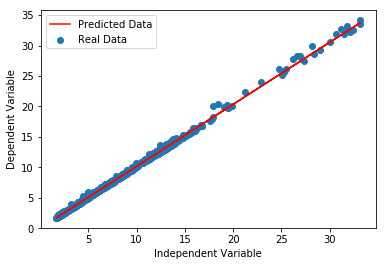

In [43]:
plt.scatter(test_d[:,0], test_d[:,1], label='Real Data')
plt.plot(test_d[:,0], y_pred_test, 'r', label='Predicted Data')
plt.xlabel('Independent Variable') 
plt.ylabel('Dependent Variable')
plt.legend()